<a href="https://colab.research.google.com/github/kazzand/TextEmbeddings/blob/master/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
!unzip '/content/gdrive/My Drive/si.zip' -d '/content/gdrive/My Drive/si'

Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/si.zip
replace /content/gdrive/My Drive/si/3_22891_23018.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: /content/gdrive/My Drive/si/3_22891_23018.png  
 extracting: /content/gdrive/My Drive/si/10_23546_23018.png  
 extracting: /content/gdrive/My Drive/si/17_24246_23018.png  
 extracting: /content/gdrive/My Drive/si/24_24959_23018.png  
 extracting: /content/gdrive/My Drive/si/31_25657_23018.png  
 extracting: /content/gdrive/My Drive/si/38_26358_23018.png  
 extracting: /content/gdrive/My Drive/si/45_27020_23018.png  
 extracting: /content/gdrive/My Drive/si/52_27731_23018.png  
 extracting: /content/gdrive/My Drive/si/59_28391_23018.png  
 extracting: /content/gdrive/My Drive/si/66_29093_23018.png  
 extracting: /content/gdrive/My Drive/si/73_29793_23018.png  
 extracting: /content/gdrive/My Drive/si/80_30493_23018.png  
 extracting: /content/gdrive/My Drive/si/87_31204_23018.png  
 extracting: /content/gdrive/My

In [0]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2

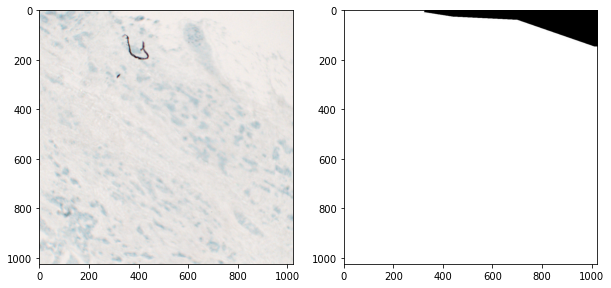

In [3]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = cv2.imread('/content/gdrive/My Drive/si/train/1070_37533_25730.png')
plt.imshow(im[:,:,:])
plt.subplot(1,2,2)
mask = cv2.imread('/content/gdrive/My Drive/masks/train/1070_37533_25730.jpg')
plt.imshow(mask, 'gray')
plt.show()

In [4]:
mask.shape

(1024, 1024, 3)

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import transforms

""" 
    This file defines every layer (or group of layers) that are inside UNet.
    At the final the architecture UNet is defined as a conjuntion of the elements created.
"""
class double_conv(nn.Module):
    ''' Applies (conv => BN => ReLU) two times. '''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    ''' First Section of U-Net. '''

    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    ''' Applies a MaxPool with a Kernel of 2x2,
        then applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()

        self.mpconv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    ''' Applies a Deconvolution and then applies applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        
        # Bilinear is used to save computational cost
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(
                in_ch//2, in_ch//2, kernel_size=2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(input=x2, pad=(diffX // 2, diffX // 2,
                                  diffY // 2, diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    ''' Applies the last Convolution to give an answer. '''

    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    ''' This Object defines the architecture of U-Net. '''

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


In [0]:
def compute_loss(y_pred, y_true):
    return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=0)),dim=0))

In [0]:
import os
import torch
import torchvision
import warnings
warnings.filterwarnings("ignore")

class my_dataset(torch.utils.data.Dataset):
    def __init__(self,path_data,path_target):
        self.path_data = path_data
        self.path_target = path_target
        self.files_data = os.listdir(os.path.join(self.path_data,"train"))
        self.files_data.sort()
        self.files_target = os.listdir(os.path.join(self.path_target,"train"))
        self.files_target.sort()
    def __len__(self):
        return len(self.files_data)
    def __getitem__ (self,i):
        data = torch.FloatTensor(cv2.resize(cv2.imread(os.path.join(self.path_data,"train",self.files_data[i])), (512,512)).T[1,:,:][None]/255).cuda()
        target = torch.FloatTensor(cv2.resize(cv2.imread(os.path.join(self.path_target,"train",self.files_target[i])), (512,512)).T/255).cuda()
        data.requires_grad_(True)
        target.requires_grad_(True)
        return (data,target)
              
train_dataset = my_dataset('/content/gdrive/My Drive/si', '/content/gdrive/My Drive/masks')
    
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)

In [0]:
a = next(iter(train_batch_gen))

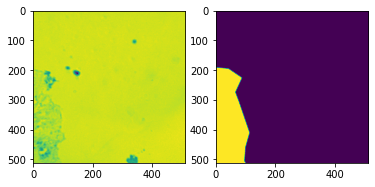

In [26]:
i = 0
plt.subplot(121)
plt.imshow(a[0][i].cpu().detach().numpy()[0,:,:])
plt.subplot(122)
plt.imshow(a[1][i].cpu().detach().numpy()[0,:,:])

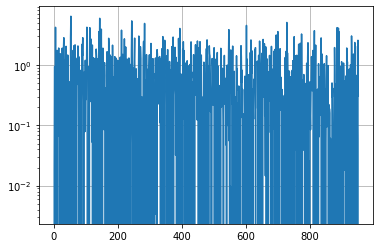

torch.Size([5, 1, 512, 512])


In [0]:
import time
from IPython.display import clear_output
model = UNet(n_channels=1,n_classes = 1);#UNet(n_class = 2);
model.cuda()
opt = torch.optim.Adam(model.parameters())

num_epochs = 400
train_loss = []

for i in range(num_epochs):
    start_time = time.time()
    model.train(True)
    for (X_batch, y_batch) in train_batch_gen:
        print(X_batch.size())
        loss = compute_loss(model(X_batch),y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        error = loss.data.detach()
        train_loss.append(error)
        
        clear_output(True)
        plt.semilogy(train_loss)
        plt.grid()
        plt.show()

In [0]:
d = im.T[1,:,:]
d = d[None]
a = model.forward(torch.FloatTensor(d/255)[None].cuda())
b = a.detach()
c = b.cpu().numpy()
calc_iou(c[0][0],mask.T)